# AI Ethics Project - STARTER

Personalization is a central aspect of many core AI systems. In this project, I will be working on a hypothetical use case for a personalized "activity recommender". The use case has a medium ethical AI risk level and involves a synthetic dataset.

IDOOU is a mobile app users can leverage to get recommendations on activities they can take in a given area, like “visiting a movie theater”, “visiting a park”, “sightseeing”, “hiking”, or “visiting a library”.


**Problem statement**:

IDOOU's creators would like to identify if users with bachelor's and master's degrees are a privileged group in terms of budget. In other words, do users with higher education credentials beyond high school have a budget >= $300 compared to users of the app who graduated from high school? 

I am tasked with designing IDOOU's newest AI model to predict the budget of its users (in US dollars) given information such as their gender, age, and education_level. I will also explore the provided data and analyze and evaluate this budget predictor's fairness and bias issues.


**Key points**:

- The training data was conducted through a user experience study of about 300,000 participants.
- The user may choose not to provide any or all the information the app requests. The training data also reflects this.
- Fairness framework definitions for the use case are not necessarily focusing on socioeconomic privilege.

In [7]:
!pip install aif360
!pip install tensorflow
!pip install jinja2
!pip install fairlearn
!pip install aif360[LawSchoolGPA]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


**Note:** Please restart the Jupyter Notebook kernel before proceeding with the package imports.

In [1]:
#Importing of some needed libraries

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB

In [2]:
#Load the dataset for this project

act_rec_dataset = pd.read_csv('udacity_ai_ethics_project_data.csv')
act_rec_dataset.head()

,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
1,1741.0,89.0,Other,Bachelor’s Degree,NaN,Play: Visit a movie theater
2,140.0,22.0,NaN,Other,0.0,Play: Visit a movie theater
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library


In [4]:
act_rec_dataset.to_csv('udacity_ai_ethics_project_data.csv', index = False)

## Step 1: Data Pre-Processing and Evaluation

For this problem statement, I will need to prepare a dataset with all categorical variables, which requires the following pre-processing steps:


- Remove the NA values from the dataset
- Convert Age and Budget (in dollars) to categorical columns with the following binning:

> Bins for Age: 18-24, 25-44, 45-65, 66-92

> Bins for Budget: >=300, <300

In [3]:
act_rec_dataset.head()

,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
1,1741.0,89.0,Other,Bachelor’s Degree,NaN,Play: Visit a movie theater
2,140.0,22.0,NaN,Other,0.0,Play: Visit a movie theater
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library


In [4]:
# To rename some columns in the dataset

act_rec_dataset.rename(columns = {'Budget (in dollars)':'Budget_dollars',
                                  'With children?':'With_Children'}, inplace = True)

In [5]:
act_rec_dataset.head(50)

,Budget_dollars,Age,Gender,Education_Level,With_Children,Recommended_Activity
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
1,1741.0,89.0,Other,Bachelor’s Degree,NaN,Play: Visit a movie theater
2,140.0,22.0,NaN,Other,0.0,Play: Visit a movie theater
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library
5,3335.0,35.0,Male,Bachelor’s Degree,1.0,Play: Go shopping
6,4044.0,42.0,Non-binary,Master’s Degree,0.0,Explore: Go sightseeing
7,3110.0,33.0,NaN,Bachelor’s Degree,NaN,Learn: Visit a library
8,2410.0,30.0,Transgender,Master’s Degree,1.0,Stay in: Color
9,4133.0,43.0,Transgender,Master’s Degree,1.0,Stay in: Color


In [6]:
print(act_rec_dataset)

        Budget_dollars   Age       Gender    Education_Level  With_Children  \
0               3258.0  29.0  Transgender  Bachelor’s Degree            0.0   
1               1741.0  89.0        Other  Bachelor’s Degree            NaN   
2                140.0  22.0          NaN              Other            0.0   
3                179.0  23.0   Non-binary              Other            0.0   
4               3479.0  79.0   Non-binary    Master’s Degree            1.0   
...                ...   ...          ...                ...            ...   
299995          3316.0  47.0         Male  Bachelor’s Degree            0.0   
299996           360.0  85.0  Transgender    Master’s Degree            NaN   
299997           285.0  22.0       Female              Other            1.0   
299998          1528.0  46.0          NaN    Master’s Degree            0.0   
299999          4577.0  34.0   Non-binary    Master’s Degree            NaN   

               Recommended_Activity  
0         Sta

In [7]:
# To remove the apostrophe sign from all characters in the Education_Level column using the 
# replace function

act_rec_dataset['Education_Level'] = act_rec_dataset['Education_Level'].replace(['Bachelor’s Degree', 'Master’s Degree'], 
                                                                               ['Bachelor Degree', 'Master Degree'])

In [7]:
act_rec_dataset.head()

,Budget_dollars,Age,Gender,Education_Level,With_Children,Recommended_Activity
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
1,1741.0,89.0,Other,Bachelor’s Degree,NaN,Play: Visit a movie theater
2,140.0,22.0,NaN,Other,0.0,Play: Visit a movie theater
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library


### Descriptive Analysis

In [8]:
print(act_rec_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Budget_dollars        300000 non-null  float64
 1   Age                   300000 non-null  float64
 2   Gender                250201 non-null  object 
 3   Education_Level       256408 non-null  object 
 4   With_Children         216151 non-null  float64
 5   Recommended_Activity  300000 non-null  object 
dtypes: float64(3), object(3)
memory usage: 13.7+ MB
None


In [10]:
print(act_rec_dataset.describe())

       Budget_dollars            Age  With_Children
count   300000.000000  300000.000000  216151.000000
mean      1209.418510      30.805787       0.612831
std       1519.756713      15.810230       0.487104
min          1.000000      18.000000       0.000000
25%        131.000000      20.000000       0.000000
50%        260.000000      23.000000       1.000000
75%       2229.000000      37.000000       1.000000
max       4999.000000      91.000000       1.000000


### Remove NULL values

In this section, I will be identifying and removing all the null values from the dataset.

In [11]:
# To determine the total number of empty values in the dataset for each column

act_rec_dataset.isnull().sum()

Budget_dollars              0
Age                         0
Gender                  49799
Education_Level         43592
With_Children           83849
Recommended_Activity        0
dtype: int64

In [14]:
len(act_rec_dataset)

300000

In [17]:
# To drop the null values in the "Gender", "Education_level", and "With_Children" columns.

def drop(df):
    for i in df.columns:
        if ((df[i].isnull().sum()/len(df))*100) > 30:
            df.dropna([i], axis = 1, inplace = True)
        elif df[i].dtype == 'O':  # For object type columns
            df[i].fillna(df[i].mode()[0], inplace=True)  # Fill null values with the mode
        elif df[i].dtype in ['int64', 'float64']:  # For numeric type columns
            df[i].fillna(df[i].median(), inplace=True)  # Fill null values with the median


In [18]:
drop(act_rec_dataset)

In [19]:
act_rec_dataset.isnull().sum()

Budget_dollars          0
Age                     0
Gender                  0
Education_Level         0
With_Children           0
Recommended_Activity    0
dtype: int64

In [20]:
act_rec_dataset.columns

Index(['Budget_dollars', 'Age', 'Gender', 'Education_Level', 'With_Children',
       'Recommended_Activity'],
      dtype='object')

In [21]:
# Top 10 rows of the dataframe without null values

act_rec_dataset.head(20)

,Budget_dollars,Age,Gender,Education_Level,With_Children,Recommended_Activity
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
1,1741.0,89.0,Other,Bachelor’s Degree,1.0,Play: Visit a movie theater
2,140.0,22.0,Male,Other,0.0,Play: Visit a movie theater
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library
5,3335.0,35.0,Male,Bachelor’s Degree,1.0,Play: Go shopping
6,4044.0,42.0,Non-binary,Master’s Degree,0.0,Explore: Go sightseeing
7,3110.0,33.0,Male,Bachelor’s Degree,1.0,Learn: Visit a library
8,2410.0,30.0,Transgender,Master’s Degree,1.0,Stay in: Color
9,4133.0,43.0,Transgender,Master’s Degree,1.0,Stay in: Color


In [22]:
act_rec_dataset.isnull().sum()

Budget_dollars          0
Age                     0
Gender                  0
Education_Level         0
With_Children           0
Recommended_Activity    0
dtype: int64

### Binning

In this section, I will be using bins to convert some numerical columns to categorical columns.

In [23]:
# For the Budget_dollars column

# Define the bin edges to categorize the values
bins = [0, 300, 1000000]  # The first bin includes values from 0 to 300 (exclusive), and the second bin includes values from 300 (inclusive) to 1000000 (inclusive)

# Define labels for the bins
labels = ['<300', '>=300']  # Label '<300' is assigned to values falling in the first bin (less than 300), and '>=300' is assigned to values falling in the second bin (300 or more)


In [24]:
# To convert the Budget_dollars column to a categorical column

act_rec_dataset['Budget_dollars'] = pd.cut(act_rec_dataset['Budget_dollars'], bins, labels = labels)

In [25]:
act_rec_dataset.head(25)

,Budget_dollars,Age,Gender,Education_Level,With_Children,Recommended_Activity
0,>=300,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
1,>=300,89.0,Other,Bachelor’s Degree,1.0,Play: Visit a movie theater
2,<300,22.0,Male,Other,0.0,Play: Visit a movie theater
3,<300,23.0,Non-binary,Other,0.0,Play: Visit a movie theater
4,>=300,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library
5,>=300,35.0,Male,Bachelor’s Degree,1.0,Play: Go shopping
6,>=300,42.0,Non-binary,Master’s Degree,0.0,Explore: Go sightseeing
7,>=300,33.0,Male,Bachelor’s Degree,1.0,Learn: Visit a library
8,>=300,30.0,Transgender,Master’s Degree,1.0,Stay in: Color
9,>=300,43.0,Transgender,Master’s Degree,1.0,Stay in: Color


In [17]:
# To confirm that there is no null value

act_rec_dataset.Budget_dollars.isnull().sum()

0

In [26]:
# For the Age column

bins = [17,24,44,65,92]
labels = ['18-24', '25-44', '45-65', '66-92']

In [27]:
# To convert the Age column to a categorical column

act_rec_dataset['Age'] = pd.cut(act_rec_dataset['Age'], bins, labels = labels)

In [28]:
act_rec_dataset.tail(25)

,Budget_dollars,Age,Gender,Education_Level,With_Children,Recommended_Activity
299975,>=300,25-44,Other,Master’s Degree,1.0,Explore: Go sightseeing
299976,<300,18-24,Male,Master’s Degree,1.0,Play: Go shopping
299977,>=300,25-44,Male,Bachelor’s Degree,1.0,Explore: Hike
299978,<300,18-24,Non-binary,Did Not Graduate HS,0.0,Play: Go shopping
299979,<300,18-24,Transgender,Other,1.0,Play: Go shopping
299980,<300,18-24,Non-binary,Did Not Graduate HS,0.0,Play: Go shopping
299981,>=300,25-44,Male,Master’s Degree,0.0,Play: Visit a movie theater
299982,>=300,45-65,Non-binary,Master’s Degree,1.0,Stay in: Play a game
299983,>=300,25-44,Male,Bachelor’s Degree,0.0,Stay in: Watch calming TV
299984,<300,18-24,Female,High School Grad,1.0,Play: Go shopping


In [29]:
# To confirm that there is no null value

act_rec_dataset.Age.isnull().sum()

0

### Evaluate bias issues in the dataset

Next, let's take a look at potential hints of data bias in the variables, particularly the "Gender", "Age", and "Education" variables.

In this section, I will articulate the representativeness in the dataset, by answering the question "Is there a greater representation of certain groups over others?"

In [22]:
# Using the Seaborn library color palette to determine the base color for the visuals

base_color = sns.color_palette('colorblind')[0]

Text(0.5, 1.0, 'Age Category Representativeness')

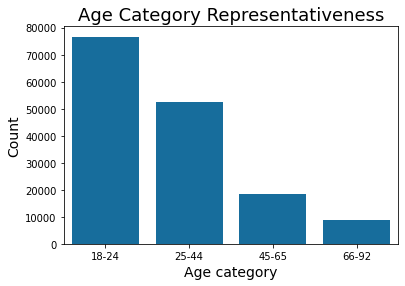

In [23]:
# To plot the representativeness of the age category in the dataset

sns.countplot(data = act_rec_dataset, x = 'Age', color = base_color)
plt.xlabel('Age category', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Age Category Representativeness', fontsize = 18)

**Observations:**
> * The '18-24' age catefory happens to be the highest in terms of representation compared to the other age categories

Text(0.5, 1.0, 'Gender Representativeness')

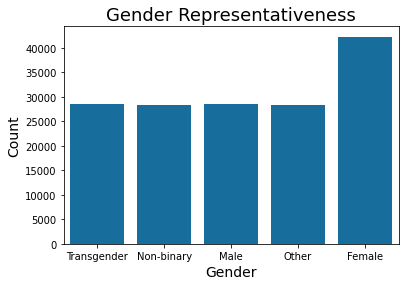

In [24]:
sns.countplot(data = act_rec_dataset, x = 'Gender', color = base_color)
plt.xlabel('Gender', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Gender Representativeness', fontsize = 18)

**Observations:**
> * From the visual above, we can notice that the Female gender is more represented compared to the other gender.

Text(0.5, 1.0, 'Education Level Representativeness')

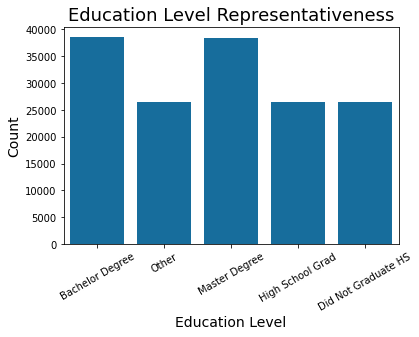

In [25]:
sns.countplot(data = act_rec_dataset, x = 'Education_Level', color = base_color)
plt.xlabel('Education Level', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(rotation = 30)
plt.title('Education Level Representativeness', fontsize = 18)

**Observation:**
> * The bar chart above is showing that the Bachelor's Degree and Master's Degree Education level is more represented compared to the other education levels.

Text(0.5, 1.0, 'Recommended Activity Representativeness')

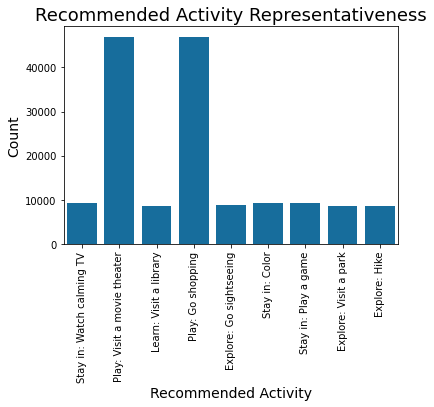

In [26]:
sns.countplot(data = act_rec_dataset, x = 'Recommended_Activity', color = base_color)
plt.xlabel('Recommended Activity', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(rotation = 90)
plt.title('Recommended Activity Representativeness', fontsize = 18)

**Observation:**
> * The bar chart above is showing that recommended activities involving visiting a movie theater, and going shopping are more represented compared to the other activities.

Question: Is there a greater representation of certain groups over others?

**Your answer:**

* For the Age group representation, individuals between the age of 18-24 years are of greater representation compared to the other age groups.
* As regards the Gender representation analysis, the corresponding visual above shpws that the Female gender is more represented compared to the other genders.
* The Education Level analysis visual above shows that the Bachelor's Degree and Master's Degree education level are of greater representation compared to the other education levels.

Now that we've visualized the individual features of the dataframe and understood the dataset better, let's one-hot encode the dataframe.

In [27]:
#The variable act_rec_dataset should contain the one-hot encoded variables

act_rec_dataset

,Budget_dollars,Age,Gender,Education_Level,With_Children,Recommended_Activity
0,>=300,25-44,Transgender,Bachelor Degree,0.0,Stay in: Watch calming TV
3,<300,18-24,Non-binary,Other,0.0,Play: Visit a movie theater
4,>=300,66-92,Non-binary,Master Degree,1.0,Learn: Visit a library
5,>=300,25-44,Male,Bachelor Degree,1.0,Play: Go shopping
6,>=300,25-44,Non-binary,Master Degree,0.0,Explore: Go sightseeing
...,...,...,...,...,...,...
299984,<300,18-24,Female,High School Grad,1.0,Play: Go shopping
299989,<300,18-24,Other,Did Not Graduate HS,1.0,Play: Visit a movie theater
299990,>=300,25-44,Transgender,Bachelor Degree,0.0,Explore: Go sightseeing
299995,>=300,45-65,Male,Bachelor Degree,0.0,Explore: Hike


### To Encode the Budget_dollars column

In [28]:
# One-Hot Encoding using dummies

act_rec_dataset = pd.get_dummies(act_rec_dataset)
print(act_rec_dataset)

        With_Children  Budget_dollars_<300  Budget_dollars_>=300  Age_18-24  \
0                 0.0                    0                     1          0   
3                 0.0                    1                     0          1   
4                 1.0                    0                     1          0   
5                 1.0                    0                     1          0   
6                 0.0                    0                     1          0   
...               ...                  ...                   ...        ...   
299984            1.0                    1                     0          1   
299989            1.0                    1                     0          1   
299990            0.0                    0                     1          0   
299995            0.0                    0                     1          0   
299997            1.0                    1                     0          1   

        Age_25-44  Age_45-65  Age_66-92  Gender_Fem

In [29]:
act_rec_dataset.head(20)

,With_Children,Budget_dollars_<300,Budget_dollars_>=300,Age_18-24,Age_25-44,Age_45-65,Age_66-92,Gender_Female,Gender_Male,Gender_Non-binary,...,Education_Level_Other,Recommended_Activity_Explore: Go sightseeing,Recommended_Activity_Explore: Hike,Recommended_Activity_Explore: Visit a park,Recommended_Activity_Learn: Visit a library,Recommended_Activity_Play: Go shopping,Recommended_Activity_Play: Visit a movie theater,Recommended_Activity_Stay in: Color,Recommended_Activity_Stay in: Play a game,Recommended_Activity_Stay in: Watch calming TV
0,0.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,1,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
4,1.0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,1.0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
6,0.0,0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
8,1.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,1.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11,1.0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
13,0.0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
17,1.0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [30]:
act_rec_dataset['Education_Level_Master Degree']

0         0
3         0
4         1
5         0
6         1
         ..
299984    0
299989    0
299990    0
299995    0
299997    0
Name: Education_Level_Master Degree, Length: 156317, dtype: uint8

The next thing is to visualize the interactions between the categorical variables, and also identify if there are trends trends outside of those identified in the previous section?

**Hint**: I'll be using a multicollinearity matrix.

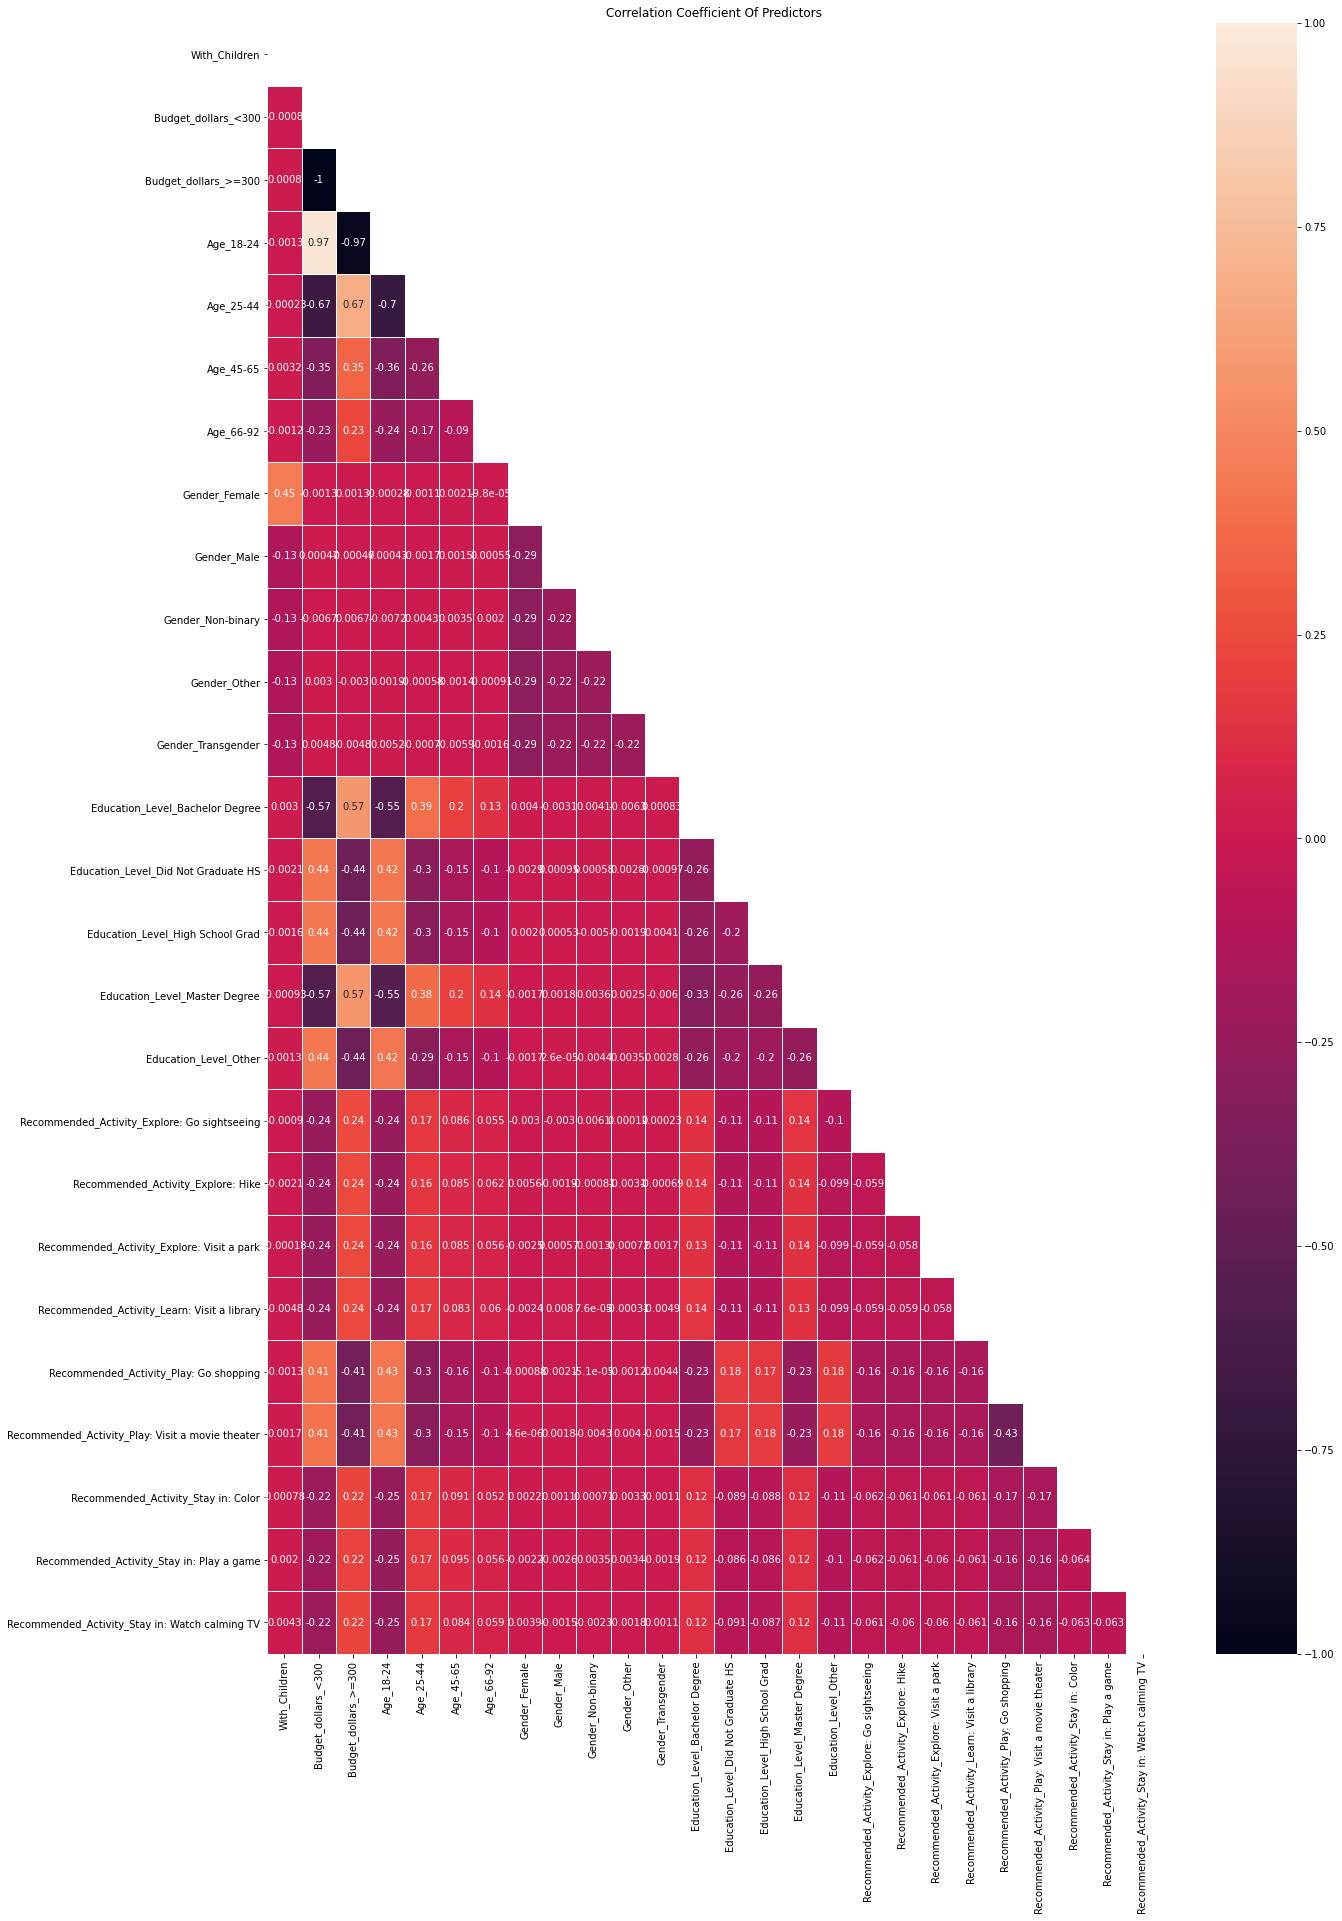

In [32]:
# set figure size
#act_rec_dataset.plot(figsize=(25,10))
plt.figure(figsize=(20,30))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(act_rec_dataset.corr(), dtype=bool))

# generate heatmap
sns.heatmap(act_rec_dataset.corr(), annot=True, linewidths = .9, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

Question: What trends were spotted in the interactions between the categoritcal variables?

**Your answer:**

We can observe from the visual above that there is high correlation between `Education_Level_Did Not Graduate HS` and `Education_Level_Others` variables.

* There's a positive correlation between the `Education_Level_Master's Degree` independent variable and the `Budget_dollars_>=300` dependent variable.

* There's a positive correlation between the `Education_Level_Bachelor's Degree` independent variable and the `Budget_dollars_>=300` dependent variable.

* There's a positive correlation also between the age groups of `25-44`, `45-65`, `66-92` and the `Budget_dollars_>=300` dependent variable. 





For the purposes of this project, we will drop the following elements from the dataframe:

- Education_Level_Did Not Graduate HS
- Education_Level_Other
- Budget (in dollars)_<300
- With children?

In [33]:
#We drop certain variables that are highly correlated and irrelevant

act_rec_dataset = act_rec_dataset.drop(columns=['Education_Level_Did Not Graduate HS', 'Education_Level_Other', 'Budget_dollars_<300', 'With_Children'])
act_rec_dataset.head()

,Budget_dollars_>=300,Age_18-24,Age_25-44,Age_45-65,Age_66-92,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Other,Gender_Transgender,...,Education_Level_Master Degree,Recommended_Activity_Explore: Go sightseeing,Recommended_Activity_Explore: Hike,Recommended_Activity_Explore: Visit a park,Recommended_Activity_Learn: Visit a library,Recommended_Activity_Play: Go shopping,Recommended_Activity_Play: Visit a movie theater,Recommended_Activity_Stay in: Color,Recommended_Activity_Stay in: Play a game,Recommended_Activity_Stay in: Watch calming TV
0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,1,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
5,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,1,0,1,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0


### Evaluate fairness issues

Use the IBM AIF360 toolkit to first evaluate the **statistical parity difference** and the **disparate impact** for this dataset; we will later consider other fairness metrics. Interpret your findings - is there bias in the proposed problem statement? If yes, what group is benefitting?

**Hint**: Use the BinaryLabelDataset and the BinaryLabelDatasetMetric functions for the fairness evaluation. The reported Statistical Parity Difference may be within -0.64 and -0.55, and the Disparate impact value may be within 0.136 and 0.0150.

In [34]:
# Fairness evaluation of the original dataset

# Bachelor and Master degrees are privileged groups in terms of budget.

privileged_groups = [{'Education_Level_Master Degree' : 1}, {'Education_Level_Bachelor Degree' : 1}]
unprivileged_groups = [{'Education_Level_High School Grad' : 1}]

favorable_label = 1
unfavorable_label = 0

binary_act_dataset = BinaryLabelDataset(favorable_label = favorable_label, 
                                        unfavorable_label = unfavorable_label, 
                                        df = act_rec_dataset, label_names = 
                                       ['Budget_dollars_>=300'], protected_attribute_names = 
                                        ['Education_Level_Master Degree', 
                                         'Education_Level_Bachelor Degree', 
                                         'Education_Level_High School Grad'], 
                                         instance_weights_name = None)



In [35]:
# To calculate the statistical parity difference and the disparate impact

orig_metric_act_dataset = BinaryLabelDatasetMetric(binary_act_dataset, unprivileged_groups = unprivileged_groups,
                                                  privileged_groups = privileged_groups)

#print("Statistical Parity Difference =")
#print(f"Disparate impact =")

In [36]:
def mean_difference(orig_metric_act_dataset):
    return orig_metric_act_dataset.statistical_parity_difference()

In [37]:
# For the statistical parity difference

orig_metric_act_dataset.statistical_parity_difference()

-0.9834450813458532

In [38]:
# For the disparate impact

orig_metric_act_dataset.disparate_impact()

0.008868535202593118

Question: Evaluate the fairness metrics. What are the findings? Is there bias in the proposed problem statement? If yes, what group is benefitting?

**Your answer:**

>From the codes above, we can see that the dataset have a statistical parity difference of `-0.9834` and a disparate impact of `0.0088`. This is a preprocessing fairness evaluation of the dataset.

>It shows that there is bias in the proposed problem statement with the Education_Level_Bachelor degree and Education_Level_Master degree groups as benefactors.

## Step 2: Investigate an ML model on the problematic Dataset

For this project, we are using a train-test-validation split.

I have available boilerplate for training 2 ML models on this dataset - I will need to train these models and use the methods we covered in this course to identify and evaluate their performance (**using the accuracy metric and confusion matrix**).

As part of this process, I will also analyze and evaluate fairness and bias issues in the AI solution.

In [37]:
# To split the binary act dataset into training, test, and validate datasets

(orig_train,
 orig_validate,
 orig_test) = binary_act_dataset.split([0.5, 0.8], shuffle=True)

### Evaluation of the Fairness Metrics on Train Dataset

In [38]:
# Fairness Metrics Evaluation on the Train Dataset
# To calculate the statistical parity difference and the disparate impact

orig_train_metric_act_dataset = BinaryLabelDatasetMetric(orig_train, unprivileged_groups = unprivileged_groups,
                                                  privileged_groups = privileged_groups)

#print("Statistical Parity Difference =")
#print(f"Disparate impact =")

In [39]:
def mean_difference(orig_train_metric_act_dataset):
    return orig_train_metric_act_dataset.statistical_parity_difference()

In [40]:
# For the statistical parity difference

orig_train_metric_act_dataset.statistical_parity_difference()

-0.9830459799434815

In [43]:
# For the disparate impact

orig_train_metric_act_dataset.disparate_impact()

0.008598442499306608

In [41]:
#Source: Helper code snippet from https://github.com/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb
def test(dataset, model, thresh_arr):
    y_val_pred_prob = model.predict_proba(dataset.features)
    y_val_pred = model.predict(dataset.features)
    pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs, y_val_pred

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print(f"Threshold corresponding to Best balanced accuracy: {thresh_arr[best_ind]:6.4f}")
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [48]:
# Using the Gaussian Naive Bayes model for training and predicting

GNB_model = GaussianNB().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights) 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, gnb_pred = test(dataset=orig_test,
                   model=GNB_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.9864
Corresponding average odds difference value: -0.4861
Corresponding statistical parity difference value: -0.9878
Corresponding equal opportunity difference value: -0.8824
Corresponding Theil index value: 0.0061


#### Observations

**Fairness Metrics Preprocessing**

From the metrics above we can see that the Gaussian Naive Bayes model have a threshold corresponding to best balanced accuracy of `0.0100`, a best balanced accuracy of `0.9868`, a corresponding average odds difference value of `-0.4762`, a corresponding statistical parity difference value of `-0.9887`, a corresponding equal opportunity difference value of `-0.8837`, and a corresponding Theil index value of `0.0058`.

In [42]:
nb = GaussianNB()
nb.fit(orig_train.features, orig_train.labels.ravel())

GaussianNB()

In [43]:
Gaussian_Accuracy = nb.score(orig_test.features, orig_test.labels.ravel())

In [48]:
Gaussian_Accuracy

0.9866299897645855

In [44]:
# Using the Logistic Regression model for training the train data sets

LR_model = LogisticRegression().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights)

In [49]:
#Load the Logistic Regression model

# Logistic Regression for predicting the test data sets

thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, lr_pred = test(dataset=orig_test,
                   model=LR_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2700
Best balanced accuracy: 0.9950
Corresponding average odds difference value: -0.5470
Corresponding statistical parity difference value: -0.9931
Corresponding equal opportunity difference value: -1.0000
Corresponding Theil index value: 0.0048


#### Observations

**Fairness Metrics Preprocessing**

From the metrics above we can see that the Logistic Regression model have a threshold corresponding to best balanced accuracy of `0.3000`, a best balanced accuracy of `0.9958`, a corresponding average odds difference value of `-0.5357`, a corresponding statistical parity difference value of `-0.9924`, a corresponding equal opportunity difference value of `-1.0000`, and a corresponding Theil index value of `0.0039`.

In [45]:
lr = LogisticRegression()
lr.fit(orig_train.features, orig_train.labels.ravel())

LogisticRegression()

In [46]:
LogisticRegression_Accuracy = lr.score(orig_test.features, orig_test.labels.ravel())

In [53]:
LogisticRegression_Accuracy

0.9958738485158649

### Confusion Matrix Evaluation of the GaussianNB model

In [50]:
# To evaluate the confusion matrix of the GaussianNB model

cm = confusion_matrix(orig_test.labels.ravel(), gnb_pred)

In [51]:
cm

array([[15451,   384],
       [   45, 15384]])

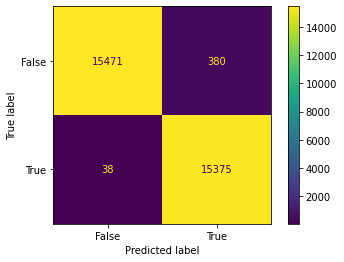

In [56]:
# To visualize the confusion matrix of the GaussianNB model

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

#### Observation

From the confusion matrix visual above, we can notice that the Gaussian Naive Bayes model have a True Positive result of `15471` of the total number of predictions, a False Positive result of `380` of the total number of predictions, a True Negative result of `15375` of the total number of predictions, and False Negative result of `38` of the total number of predictions.

We can deduce from the confusion matrix visual above that Gaussian Naive Bayes model has a Type 1 error of `380` which means that `380` of the predcited values that the budget is >= 300 is false.

The model also has a Type 2 error of `38` which means the `38` of the predicted values that the budget is not >= 300 is false. 

### Confusion Matrix Evaluation of the LogisticRegression model

In [57]:
# To evaluate the confusion matrix of the LogisticRegression model

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(orig_test.labels.ravel(), lr_pred)

In [58]:
cm

array([[15842,     9],
       [  120, 15293]])

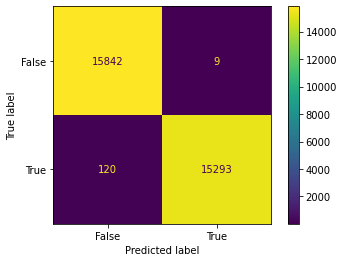

In [59]:
# To visualize the confusion matrix of the LogisticRegression model

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

#### Observation

From the confusion matrix visual above, we can notice that the Logistic Regression model have a True Positive result of `15842` of the total number of predictions, a False Positve result of `9` of the total number of predictions, a True Negative result of `15293` of the total number of predictions, and True Positive result of `120` of the total number of predictions.

We can deduce from the confusion matrix visual above that Logistic Regression model has a Type 1 error of `9` which means that `9` of the predcited values that the budget is >= 300 is false.

The model also has a Type 2 error of `120` which means the `120` of the predicted values that the budget is not >= 300 is false. 

### Visualization of the Gaussian NB Model Accuracy on the Test Dataset

In [60]:
#Fill IN
#Compare the model accuracy on test dataset either in a bar plot or table format

# Visualization of the GaussianNB() model Accuracy on the test dataset

gnb_model_viz = pd.DataFrame({'Actual-Values': np.array(orig_test.labels.ravel()).flatten(), 
                       'Predicted-Values': gnb_pred.flatten()})
gnb_model_viz.head(20)

,Actual-Values,Predicted-Values
0,1.0,1.0
1,0.0,0.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,0.0,0.0
6,0.0,0.0
7,1.0,1.0
8,1.0,1.0
9,0.0,0.0


### Visualization of the LogisticRegression Model Accuracy on the Test Dataset

In [61]:
# Visualization of the LogisticRegression() model accuracy on the test dataset

lr_model_viz = pd.DataFrame({'Actual-Values': np.array(orig_test.labels.ravel()).flatten(), 
                       'Predicted-Values': lr_pred.flatten()})
lr_model_viz.head(20)

,Actual-Values,Predicted-Values
0,1.0,1.0
1,0.0,0.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,0.0,0.0
6,0.0,0.0
7,1.0,1.0
8,1.0,1.0
9,0.0,0.0


### Evaluation of the Fairness Metrics on Test Dataset

In [104]:
#FILL IN Optional
#Compare the fairness metrics on test dataset

dataset = orig_test

# To calculate the statistical parity difference and the disparate impact

orig_metric_act_test_dataset = BinaryLabelDatasetMetric(dataset, unprivileged_groups = unprivileged_groups,
                                                  privileged_groups = privileged_groups)

#print("Statistical Parity Difference =")
#print(f"Disparate impact =")

In [105]:
def mean_difference(orig_metric_act_test_dataset):
    return orig_metric_act_test_dataset.statistical_parity_difference()

In [64]:
# For the statistical parity difference

orig_metric_act_test_dataset.statistical_parity_difference()

-0.983786371180255

In [65]:
# For the disparate impact

orig_metric_act_test_dataset.disparate_impact()

0.008108150315284616

#### Observations

By running the `BinaryLabelDatasetMetrics` on the test dataset, we can observe that the statistical parity difference is `-0.984`, and the disparate impact value is `0.0081`

Question: Interpret and compare the results of each model. What do you find in the false negative and false positive of each model? What about the fairness metrics?

**Answer:**

#### Confusion Matrix/Accuracy of Each Model Comparison

* For the GaussianNB model, the accuracy is `0.9874`, compared to the LogisticRegression model with an accuracy of `0.9955`
* We can observe the Gaussian model confusion matrix visual showing that `15631` of the total number of predictions that the budget is not >= 300 turns out to be positive compared to the LogisticRegression model confusion matrix visual showing that `15983` of the total number of predictions that the budget is not >= 300 is positive.
* The Gaussian model confusion matrix visual is showing that `360` of the total number of predictions that the budget is not >= 300 turns out to be false while the LogisticRegression model confusion matrix visual is also showing that `8`of the total number of predictions that the budget is not >= is false.
* The Gaussian model confusion matrix visual is showing that `15233` of the total number of predictions that the budget is >= 300 turns out be true while the LogisticRegression model confusion matrix visual is showing that `15144` of the total number of predictions that the budget is >= 300 is true.
* We can also observe that the Gaussian model confusion matrix visual showing that `40` of the total number of predictions that the budget is >= 300 turns out to be false compared to the LogisticRegression model confusion matrix visual showing that `129` of the total number of predictions that the budget is >= 300 is false.


#### Fairness Metrics

>We can see that the Gaussian Naive Bayes model have a threshold corresponding to best balanced accuracy of `0.0100`, a best balanced accuracy of `0.9873`, a corresponding average odds difference value of `-0.4997`, a corresponding statistical parity difference value of `-0.9888`, a corresponding equal opportunity difference value of `-0.9189`, and a corresponding Theil index value of `0.0055`, while the Logistic Regression model have a threshold corresponding to best balanced accuracy of `0.3300`, a best balanced accuracy of `0.9955`, a corresponding average odds difference value of `-0.5420`, a corresponding statistical parity difference value of `-0.9930`, a corresponding equal opportunity difference value of `-1.0000`, and a corresponding Theil index value of `0.0043`.

Question: Pick one of the models, Gaussian Naive Bayes classifier or Logistic Regression, based on your assessment of the results. Briefly explain your reason.

**Your answer:**

#### Logistic Regression

>From the results of the two models (Gaussian Naive Bayes Classifier and the Logistic Regression model), I will pick the Logistic Regression model because of the accuracy model. With an accuracy of 0.

## Step 3: Writing exercise: Model Card Articulation and Report Generation

Begin articulating the elements of the model card (3-5 sentences/bullets for each section). Please delineate bullet points using two hyphens, as show in the example below.

As part of the intended use section, I articulated how elements of **interpretability**, **privacy**, and **fairness** can be designed into the user interaction elements of the use case. **Hint:** Should IDOOU prompt the user to check whether the budget predictor model's results are correct?

In [106]:
model_details = """
-- Budget Predicter AI is a model that offers personalized predictions if a budget is >= 300 or not
by using features such as Age, Gender, Education Level and Recommended Activities. 
-- Logistic Regression and Gaussian Naive Bayes classifucation model were utilized for predicting the
budget of each users based on some given features.
-- In this model, the features that influences the outcome of predictions are independent of each other.
There is little or no multicollinearity among the indepenent variable. Also note that the Logistic
Regression model was selected as a result of evaluation of its accuracy score and confusion matrix 
visual in comparison with the Gaussian Naive Bayes model.
"""
intended_use = """
-- IDOOU is a mobile app users can leverage to get recommendations on activities. The creator of this
app would like to identify if users with bachelor's and master's degree are a privileged group in terms
of budget.
-- The intended users of this model are users that are either High school grad, users with bachelor's
degree or users with master's degree of all genders that wants to use IDOOU to get recommendations on
activities.
-- Use cases out of this scope is whether or not a user have a child, or users that did not graduate
from High school.
"""
factors = """
-- The education level of the users affects the impact of the model.
-- The age group of the users affect the impact of the model.
-- The gender of the users affect the impact of the model.
"""

Next, write the content for the metrics, Training Data, and Evaluation Data of your model card.

In [107]:
metrics = """
-- The metrics used in measuring the performance of the model are divided into accuracy/confusion matrix
metrics for accuracy scoring of the models and the fairness metrics for measuring the biasness of the 
dataset of the model.
-- The accuracy metrics of the Gaussian Naive Bayes model is showing a model accuracy of `0.9865`, while
the accuracy metrics of the Logistic Regression model showing an accuracy score of 0.9951
-- The statistical parity difference and disparate impact value metrics were evaluated to find bias in 
the dataset of the model.
"""
training_data = """
-- The binary_label_dataset was splitted with 50% of the dataset allocated to be trained.
"""
eval_data = """
-- After training the train dataset and fitting the Logistic Regression and Gaussian Naive Bayes model
to the train dataset, the test dataset was used in evaluating the models performance.
"""

## Step 4: Use Interpretability mechanisms

Use an interpretability mechanism(s) of your choice, e.g. permutation importance, LIME, etc., to understand the feature importance and model's predictions on the test dataset. **Visualize** and note down the key contributing factors - you will later incorporate this in your model card.

### Permutation Importance Interpretability Mechanism Before Bias Mitigation

In this stage, I will be using the permutation importance interpretability mechanism to understand the feature importance and the Logistic Regression model's predictions on the test dataset.

In [68]:
from sklearn.inspection import permutation_importance

model = LR_model
r = permutation_importance(model, orig_test.features, orig_test.labels.ravel(),
                          n_repeats=30,
                          random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{binary_act_dataset.feature_names[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Age_18-240.241 +/- 0.001
Education_Level_Bachelor Degree0.188 +/- 0.001
Education_Level_Master Degree0.187 +/- 0.001
Age_25-440.002 +/- 0.000
Age_45-650.001 +/- 0.000
Age_66-920.001 +/- 0.000


**Observations:**

>The results above is showing that the `Age_18-24`, `Education_Level_Bachelor Degree`, and the `Education_Level_Master_Degree` features are the most important factors that can impact the Logistic Regression model importance.

In [69]:
model = LR_model

importance=model.coef_[0]
importance=np.sort(importance)
importance

array([-7.91852059e+00, -1.79451527e-01, -1.59587304e-01, -1.35404014e-01,
       -1.25491888e-01, -1.15407000e-01, -6.79939751e-02, -4.49842096e-02,
        1.92886892e-03,  9.89221886e-03,  3.27341206e-02,  4.52367205e-02,
        1.01720123e-01,  1.27135160e-01,  1.29886296e-01,  2.01460935e-01,
        2.58795773e+00,  2.65854802e+00,  2.67257787e+00,  7.84147354e+00,
        8.16266709e+00])

In [70]:
for index,val in enumerate(importance):
    print(f"Feature : {index} has score  : {val} ")

Feature : 0 has score  : -7.918520593010121 
Feature : 1 has score  : -0.179451527026193 
Feature : 2 has score  : -0.1595873036507873 
Feature : 3 has score  : -0.13540401389578094 
Feature : 4 has score  : -0.1254918880800108 
Feature : 5 has score  : -0.11540700017266578 
Feature : 6 has score  : -0.06799397508215282 
Feature : 7 has score  : -0.044984209568373595 
Feature : 8 has score  : 0.0019288689217906644 
Feature : 9 has score  : 0.009892218858212551 
Feature : 10 has score  : 0.03273412058604847 
Feature : 11 has score  : 0.0452367205490327 
Feature : 12 has score  : 0.10172012302921384 
Feature : 13 has score  : 0.12713516033965327 
Feature : 14 has score  : 0.12988629554496844 
Feature : 15 has score  : 0.20146093493805595 
Feature : 16 has score  : 2.58795772786016 
Feature : 17 has score  : 2.6585480247006594 
Feature : 18 has score  : 2.6725778666081377 
Feature : 19 has score  : 7.841473540078382 
Feature : 20 has score  : 8.162667088908021 


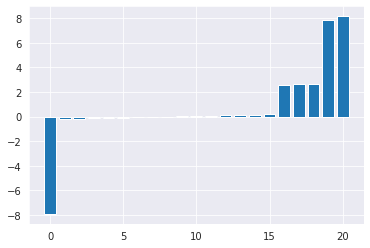

In [71]:
#plotting the features and their score in ascending order
sns.set_style("darkgrid")
plt.bar([i for i in range (len(importance))],importance)
plt.show()

Question: Which interpretability mechanism did you choose? What are the key contributing factors?

**Your answer:**

The Permutation importance interpretability mechanism was chosen for this stage. 

After evaluating the Logistic Regression model with the test dataset, here are the key contributing factors:

* Users between the age of 18 - 24.
* Users with a bachelor's degree educational level.
* Users with a master's degree educational level.



## Step 5: Apply a bias mitigation strategy

In this section of the project, I will implement a bias mitigation strategy and evaluate the improvements in fairness on the data. Using the algorithms supported by the IBM AIF360 toolkit, I may choose to apply a pre-processing, in-processing, or post-processing technique to improve the fairness of your model. Optionally, I may also consider combining multiple techniques.

**Note:** If I select an in-processing algorithm that replaces the Logistic Regression or Gaussian NB model, I will be constructing a model card around the new algorithm you have selected and revising the existing model card content from previous sections to incorporate these details.

In [108]:
#FILL IN - implement bias mitigation strategy

# Preprocessing Bias Mitigation using Reweighing

from aif360.algorithms.preprocessing.reweighing import Reweighing

RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(orig_train)
dataset_transf_train = RW.transform(orig_train)

In [109]:
RW.fit(orig_test)
dataset_transf_test = RW.transform(orig_test)

In [110]:
# Metrics for transformed data

# Explainers
from aif360.explainers import MetricTextExplainer

metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)



In [111]:
print(explainer_transf_train.disparate_impact())
print(explainer_transf_train.statistical_parity_difference())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999999
Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -5.551115123125783e-17


In [112]:
# Using the Logistic Regression model for training the train data sets

LR_transf_model = LogisticRegression().fit(dataset_transf_train.features, dataset_transf_train.labels.ravel(), dataset_transf_train.instance_weights)

In [113]:
#Load the Logistic Regression model

# Logistic Regression for predicting the test data sets

thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, lr_transf_pred = test(dataset = orig_test,
                   model=LR_transf_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.3700
Best balanced accuracy: 0.9917
Corresponding average odds difference value: -0.0236
Corresponding statistical parity difference value: -0.9520
Corresponding equal opportunity difference value: 0.0000
Corresponding Theil index value: 0.0049


In [114]:
# Logistic Regression for predicting the transformed test data sets

thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, lr_transf_pred = test(dataset = dataset_transf_test,
                   model=LR_transf_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.3700
Best balanced accuracy: 0.9792
Corresponding average odds difference value: -0.0236
Corresponding statistical parity difference value: -0.0238
Corresponding equal opportunity difference value: 0.0000
Corresponding Theil index value: 0.0049


#### Observations after bias mitigation

**Fairness Metrics Preprocessing**

From the metrics above we can see that the mitigated Logistic Regression model have a threshold corresponding to best balanced accuracy of `0.4900`, a best balanced accuracy of `0.9917`, a corresponding average odds difference value of `-0.0204`, a corresponding statistical parity difference value of `-0.9541`, a corresponding equal opportunity difference value of `0.0000`, and a corresponding Theil index value of `0.0047`.

In [115]:
from sklearn.preprocessing import StandardScaler

#Train model on given dataset

dataset = dataset_transf_train  # data to train on

scale = StandardScaler().fit(dataset.features)   # remember the scale

model = LogisticRegression()        # model to learn

X_train = scale.transform(dataset.features)      #apply the scale
y_train = dataset.labels.ravel()


model.fit(X_train, y_train, sample_weight=dataset.instance_weights)

#save model
lr_orig = model
lr_scale_orig = scale

In [116]:
#Test model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm

thresh_arr = np.linspace(0.01, 0.5, 50)

scale = lr_scale_orig

model = lr_orig                  #model to test
dataset = orig_test        #data to test on

X_test = scale.transform(dataset.features)   #apply the same scale as applied to the training data
y_test = dataset.labels.ravel()
y_test_pred_prob = model.predict_proba(X_test)


bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
    
for thresh in tqdm(thresh_arr):
    y_test_pred = (y_test_pred_prob[:,1] > thresh).astype(np.double)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_test_pred

    classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    
   
    
    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)
    
    acc = accuracy_score(y_true=dataset.labels,
                            y_pred=dataset_pred.labels)
    bal_acc_arr.append(bal_acc)
    avg_odds_diff_arr.append(classified_metric.average_odds_difference())
    disp_imp_arr.append(metric_pred.disparate_impact())
    
thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

100%|██████████| 50/50 [00:01<00:00, 32.18it/s]


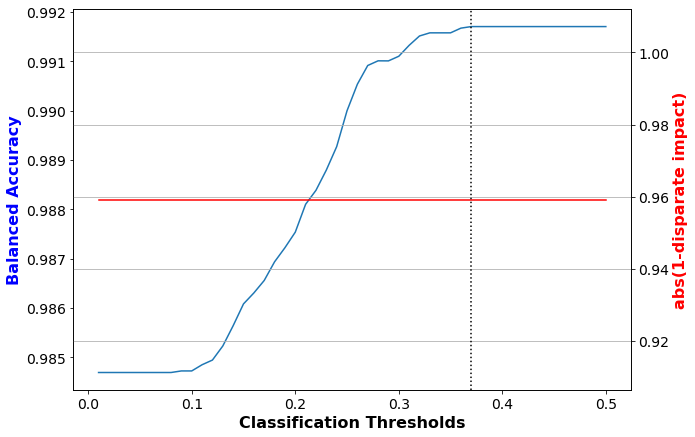

In [118]:
#Plot balanced accuracy, abs(1-disparate impact)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig('classification_thresholds1.png')

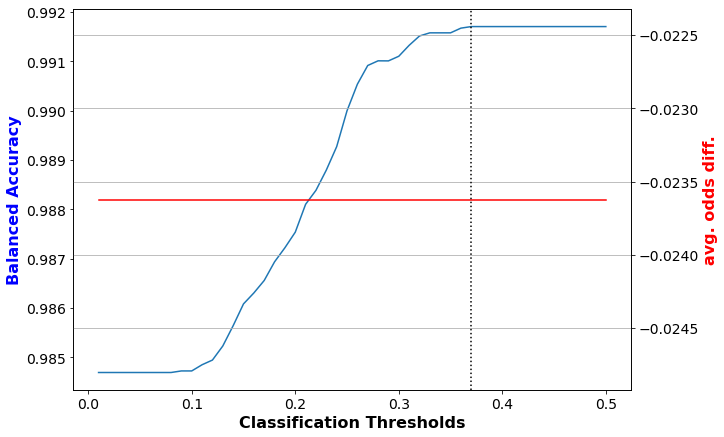

In [119]:
#Plot average odds difference
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig('classification_thresholds2.png')

In [120]:
rf_thresh_arr_orig_best = thresh_arr_best
print("Threshold corresponding to Best balance accuracy: %6.4f" % rf_thresh_arr_orig_best)
rf_best_bal_acc_arr_orig = best_bal_acc
print("Best balance accuracy: %6.4f" % rf_best_bal_acc_arr_orig)
rf_disp_imp_at_best_bal_acc_orig = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % rf_disp_imp_at_best_bal_acc_orig)
rf_avg_odds_diff_at_best_bal_acc_orig = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % rf_avg_odds_diff_at_best_bal_acc_orig)

Threshold corresponding to Best balance accuracy: 0.3700
Best balance accuracy: 0.9917
Corresponding abs(1-disparate impact) value: 0.9592
Corresponding average odds difference value: -0.0236


### Fairness Metrics After Bias Mitigation

In [121]:
# Evaluation of the test dataset after bias mitigation to get the disparate impact value

classified_metric.disparate_impact()

0.0407765054728523

In [122]:
# Evaluation of the test dataset after bias mitigation to get the average odds difference

classified_metric.average_odds_difference()

-0.02362279872488739

In [123]:
# Evaluation of the test dataset after bias mitigation to get the statistical parity difference

classified_metric.statistical_parity_difference()

-0.9519894382644382

In [124]:
# Evaluation of the test dataset after bias mitigation to get the equal opportunity difference

classified_metric.equal_opportunity_difference()

0.0

In [125]:
# Evaluation of the test dataset after bias mitigation to get the theil index

classified_metric.theil_index()

0.0048629232428642356

**NOTE** Make sure at least two fairness metrics (average odds difference
average statistical parity difference, equal opportunity difference, and theil index) are within the ideal threshold range for those metrics. A slightly higher benefit for the privileged group may still be seen, which is ok.

Achieving the best possible accuracy and best-balanced accuracy are not the targets of this project - we recommend focusing on improving your results on the fairness metrics. It is recommended to have your balanced accuracy between 85%-100% but not required.

**IMPORTANT! If less than two fairness metrics are within the ideal range, re-work on your strategy.**

Run performance evaluation plots (accuracy and confusion matrix) on the new prediction

In [126]:
### FILL IN

# To evaluate the confusion matrix of the LogisticRegression model

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(orig_test.labels.ravel(), lr_transf_pred) 

In [127]:
cm

array([[15568,   175],
       [   85, 15436]])

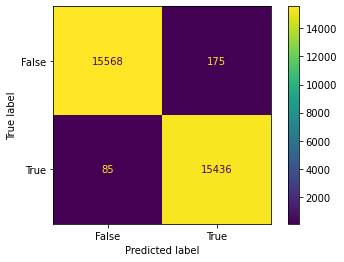

<Figure size 432x288 with 0 Axes>

In [128]:
# To visualize the confusion matrix of the LogisticRegression model

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

plt.savefig('confusion_matrix.png')

#### Observation after bias mitigation

From the confusion matrix visual above, we can notice that the mitigated Logistic Regression model have a True Positive result of `15666` of the total number of predictions, a False Positive result of `185` of the total number of predictions, a True Negative result of `15338` of the total number of predictions, and False Negative result of `75` of the total number of predictions.

We can deduce from the confusion matrix visual above that mitigated Logistic Regression model has a Type 1 error of `185` which means that `185` of the predcited values that the budget is >= 300 is false.

The model also has a Type 2 error of `75` which means the `75` of the predicted values that the budget is not >= 300 is false. 

Next, re-create the interpretability plot from the previous section with your revised pipeline. 

### Permutation Importance Interpretability Mechanism After Bias Mitigation

In [129]:
### FILL IN

from sklearn.inspection import permutation_importance

model = LR_transf_model
r = permutation_importance(model, orig_test.features, orig_test.labels.ravel(),
                          n_repeats=30,
                          random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{binary_act_dataset.feature_names[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Age_18-240.281 +/- 0.001
Education_Level_Bachelor Degree0.187 +/- 0.001
Education_Level_Master Degree0.187 +/- 0.001
Age_25-440.107 +/- 0.001
Age_45-650.050 +/- 0.000
Age_66-920.026 +/- 0.000


In [130]:
model = LR_transf_model

importance=model.coef_[0]
importance=np.sort(importance)
importance

array([-8.287898  , -0.4461278 , -0.40537158, -0.37735853, -0.17366542,
       -0.11072784, -0.07182691, -0.02404572,  0.0616154 ,  0.09244711,
        0.09683296,  0.13065278,  0.28948976,  0.41132188,  0.52740798,
        2.50171296,  2.75422723,  3.03227985,  4.14585123,  4.36475441,
        4.54317327])

In [131]:
for index,val in enumerate(importance):
    print(f"Feature : {index} has score  : {val} ")

Feature : 0 has score  : -8.28789799614566 
Feature : 1 has score  : -0.4461278019909024 
Feature : 2 has score  : -0.40537158015731994 
Feature : 3 has score  : -0.37735853317347323 
Feature : 4 has score  : -0.17366542120759962 
Feature : 5 has score  : -0.11072784335616401 
Feature : 6 has score  : -0.07182690645594253 
Feature : 7 has score  : -0.02404572286368848 
Feature : 8 has score  : 0.06161540448807952 
Feature : 9 has score  : 0.09244711396436933 
Feature : 10 has score  : 0.09683296324823802 
Feature : 11 has score  : 0.13065278169325592 
Feature : 12 has score  : 0.2894897587405066 
Feature : 13 has score  : 0.4113218831221819 
Feature : 14 has score  : 0.5274079751065304 
Feature : 15 has score  : 2.501712957018202 
Feature : 16 has score  : 2.7542272280590225 
Feature : 17 has score  : 3.0322798466440233 
Feature : 18 has score  : 4.145851226832737 
Feature : 19 has score  : 4.364754407696787 
Feature : 20 has score  : 4.543173271034338 


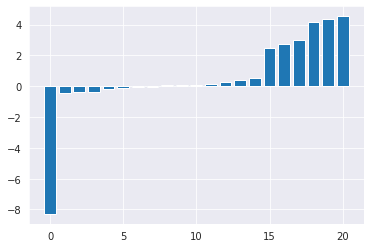

<Figure size 432x288 with 0 Axes>

In [132]:
#plotting the features and their score in ascending order
sns.set_style("darkgrid")
plt.bar([i for i in range (len(importance))],importance)
plt.show()

plt.savefig('permutation_importance.png')

Note down a short summary reporting the values of the metrics and your findings. This will be the quantitative analysis section of the model card.
- Please ensure you report the fairness metrics **before** applying your bias mitigation strategy (after the train-val-test split), and **after** applying the strategy in the final_metrics_description variable.
- Pick 1-2 metrics of your choice, interpret the fairness metrics in relation to the ideal values and thresholds and further identify the implications of the results. 

In [54]:
final_metrics_description = """
--The fairness metrics of the Logistic Regression model like the equal opportunity difference value
and statistical parity difference before bias mitigation has a score of -1.0000 and -0.9924 after 
testing the model on the test dataset
--Before the bias mitigation, the accuracy metrics of the Logistic Regression model shows that model 
has an accuracy score of 0.9958.
--After the preprocessing bias mitigation, the accuracy metrics of the Logistic Regression model has
an accuracy score of 0.9907.
--The fairness metrics of the Logistic Regression model like the equal opportunity difference value
and statistical parity difference after the preprocessing bias mitigation has a score of -1.0000 and 
-0.9924 after testing the mitigated model on the test dataset.
"""

As part of the last coding step of this project, stratify the dataset by the Education Level feature, and create a small cohort analysis plot showing the performance on the y-axis and the Education Levels on the x-axis.

In [ ]:
##Fill in



**Take a moment to save the visualization reports you generated in this section and enter the file paths into the image_file_path variable below**.

In [133]:
#FILL IN - save all visualization plots 
#from the "Apply a bias mitigation strategy" section
#plt.savefig('file_name.png')

#Replace the REPLACE_FILE_NAME placeholder with the image paths
#of the visualizations you have generated for the model card
image_file_path ="""
  <img src="classification_thresholds1.png"><br/>
  <img src="classification_thresholds2.png"><br/>
  <img src="confusion_matrix.png"><br/>
  <img src="permutation_importance.png"><br/>
"""

**Optional**: You may choose to create a cohort analysis plot showing the fairness metric values on the y-axis and the Education Levels on the x-axis.

In [ ]:
#Optional save image for the fairness corhort analysis
#plt.savefig('images/optional_fairness_cohort_analysis') 

## Step 6: Articulate the ethical implications

Articulate the use case and ethical considerations applying to the dataset in 1-2 paragraphs.

**Hints:** 
 
- Think about the limitations of the dataset, potential biases that could be introduced into the use case, and the strengths and weaknesses of your ML model.
- Ethical Considerations:
 - Human-in-the-loop considerations: Can users control aspects of the model and inspect the features? If so, briefly describe how?
 - Describe the limitations and types of bias present in the data
 - Describe the failures of the ML model
 - It must include a section on any risk mitigation strategies you applied.
 - Describe Potential harms
 - It must include key contributing factors you found from your interpretability study, both before and after applying the bias mitigation strategy.

- Caveats and Recommendations
 - Potential lack of inclusiveness in the dataset
 - Predisposition of the model to false positives and/or negatives
 - It must also include 1-2 sentences on the further ethical AI analyses you would apply if given more time beyond this project.

In [134]:
#FILL IN
ethical_considerations="""
-- The objective of the app is to remove users from having to handle the nitty-gritty details of 
finding the right activity, like determining the appropriate budget, ensuring the weather is perfect, 
and the location/accommodation is not closed, so users don't have the liberty to control most aspects 
of the model. 
-- The model for this app does not have any implications on human life, health or safety in the usage
of the model.
-- The key contributing factors from the permutation importance after the preprocessing bias mitigation
are users in all the age groups(18-24, 25-44, 45-65, 66-92), and users in the bachelor's and master's 
education level.
"""
caveats_and_recommendations="""
-- I'll recommend Logistic Regression model for classification related problems in order to have a better
accuracy score and better fairness metric scores.
-- Preprocessing and postprocesssing bias mitigation techniques should also be applied on the dataset
of the model.
-- The Logistic Regression model after the preprocessing bias mitigation seems to have higher false positives and 
lesser false negatives compared to the Logistic Regression before the bias mitigation.
-- Further ethical AI analyses I would apply beyond this project:
The Adversarial inprocessing debiasing technique will be applied beyond this project to maximize prediction
accuracy.

The Reject Option Classification (ROC) preprocessing technique can be applied beyon this project also

"""

- Business consequences
 - Potential positive impact of the IDOOU Budget Predicter AI
 - Reasons why users may lose trust in the application, and loss of revenue and brand reputation might occur to the organization

In [135]:
business_consequences="""

-- Positive Impact: With a model accuracy score of 0.99xx, the IDOOU Budget Predicter will be able to 
accurately recommend activities users can take in a given area.

-- Negative Impact: With the bias in the dataset and the little contributions of users with lesser education 
levels (lesser than high school grad) to the model, it might discourage users in that category from 
trusting the accuracy of the app. 
"""

## Document the solution in a model card

You're at the finish line! Run the last few blocks of code to generate a simple html file with your model card content and the visualizations you generated for the final version of your model.

Make sure to open the html file and check that it is reflective of your model card content before submitting.

Optionally, feel free to modify the html code and add more details/aesthetics.

In [136]:
html_code = f"""
<html>
  <head>
  </head>
  <body>
  <center><h1>Model Card - IDOOU AI Budget Predicter</h1></center>
  <h2>Model Details</h2>
  {model_details}
  <h2>Intended Use</h2>
  {intended_use}
  <h2>Factors</h2>
  {factors}
  <h2>Metrics</h2>
  {metrics}
  <h2> Training Data </h2>
  {training_data}
  <h2> Evaluation Data </h2>
  {eval_data}
  <h2>Quantitative Analysis</h2>
  {final_metrics_description}
  
  <br/><br/><b>Results of the AI model after applying the bias mitigation strategy</b><br/>
  
  <center>
  {image_file_path}
  </center>

  <h2>Ethical Considerations</h2>
  {ethical_considerations}
  <h2>Caveats and Recommendations</h2>
  {caveats_and_recommendations}
  <h2>Business Consequences</h2>
  {business_consequences}
  </body>
</html>"""
html_code = html_code.replace('--', '<br>--')

In [137]:
with open('model_card.html', 'w') as f:
    f.write(html_code)

Download and zip the .html report, the images you generated, and this Jupyter notebook, and you're ready for submission!